# DTSA 5509 Final Project
## Predicting NHL Player Performance in Future Seasons

<ins>Introduction</ins>
<br>
<br>
The National Hockey League (NHL) is home to the top performers in the sport of ice hockey. While this sport is often times fast paced and unpredictable, there are key metrics that we can analyze to forecast how an individual player's contribution to an upcoming season. This project seeks to predict player performance given data from the 2023-2024 season and called games of the 2024-2025 season (as of 10/14/2024). 

This type of analysis can help teams propose trades, set salary expectations, and formulate lines (sets of players out on the ice at one time). In order to accomplish this task, this project will utilze multiple linear regression and the k nearest neighbors algorithm to generate predictions for the value of 'Points per Games Played' or 'P/GP' on the data table.

<ins>Data Loading</ins>
<br>
<br>
The data is publicly available at https://www.nhl.com/stats/. This project will be using the summary table for the 2023-2024 Season. The NHL only allows for exports of 100 rows at a time, so we will we will merge these csvs into a single data frame in pandas
<br>

|Feature|Type|Description|
|-------|----|-----------|
|Player|string| Player Name
|S/C| char(binary, "L", "R")|  Skater Shoots/Goalie Catches
|Pos| char(class, "C", "D", "L", "R")|  Player Position
|GP| int|  Games Played
|G| int|  Goals
|A| int|  Assists
|P| int| Points
|+/-| int|  Plus-Minus (since 1959-60)
|PIM| int|  Penalty Minutes
|P/GP| float|  Points per Game Played
|EVG| int|  Even Strength Goals (since 1933-34)
|EVP| int|  Even Strength Points (since 1933-34)
|PPG| int|  Power Play Goals (since 1933-34)
|PPP| int|  Power Play Points (since 1933-34)
|SHG| int|  Shorthanded Goals (since 1933-34)
|SHP| int|  Shorthanded Points (since 1933-34)
|OTG| int|  Overtime Goals
|GWG| int|  Game Winning Goals
|S| int|  Shots (since 1959-60)
|S%| float|  Shooting Percentage (since 1959-60)
|TOI/GP| string(minutes:seconds)|  Time On Ice per Game Played (since 1997-98)
|FOW%| float|  Face-off Win Percentage (since 1997-98)


In [350]:
#Import relevant packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [359]:
#Read all CSV files into a single data frame
import glob

# Get a list of all Excel files in the directory
path = r'.'
all_files = glob.glob(path + "/Summary*.xlsx")

# Create an empty list to store the dataframes
li = []

# Loop through each file and read it into a dataframe
for filename in all_files:
    df = pd.read_excel(filename, engine='openpyxl')
    li.append(df)

# Concatenate all dataframes into one
final_df = pd.concat(li, axis=0, ignore_index=True)
final_df = final_df.sort_values(by = "P/GP", ascending = False)
print(type(df['TOI/GP'][0]))
print(f"The shape of the table is", final_df.shape)
print("The file size of the data is 766kb")
final_df.head(10)

<class 'str'>
The shape of the table is (944, 22)
The file size of the data is 766kb


,Player,S/C,Pos,GP,G,A,P,+/-,PIM,P/GP,...,PPG,PPP,SHG,SHP,OTG,GWG,S,S%,TOI/GP,FOW%
375,Macklin Celebrini,L,C,1,1,1,2,0,0,2.00,...,0,0,0,0,0,0,2,50,17:35,7.1
844,Nikita Kucherov,L,R,82,47,101,148,10,22,1.80,...,14,55,0,0,1,7,312,15.1,21:40,50
845,Nathan MacKinnon,R,C,84,52,92,144,34,52,1.71,...,11,50,0,0,2,9,412,12.6,22:48,46.4
846,Connor McDavid,L,C,79,32,102,134,30,32,1.70,...,7,45,1,1,1,5,271,11.8,21:22,51.5
847,Artemi Panarin,R,L,85,51,76,127,20,24,1.49,...,12,46,0,1,1,5,310,16.5,20:08,10
848,David Pastrnak,R,R,86,50,64,114,22,53,1.33,...,13,36,0,0,1,6,397,12.6,19:53,33.3
849,Mikko Rantanen,L,R,82,45,63,108,19,52,1.32,...,15,42,0,0,0,9,280,16.1,22:54,53.7
854,Kirill Kaprizov,L,L,78,47,53,100,13,36,1.28,...,19,43,0,0,2,8,288,16.3,21:34,0
850,Leon Draisaitl,L,C,84,42,65,107,22,82,1.27,...,22,40,0,2,2,7,222,18.9,20:42,57.1
851,Auston Matthews,L,C,84,69,38,107,33,20,1.27,...,18,29,0,1,3,8,384,18.0,20:59,53.6


<ins>Data Cleaning</ins>
<br>
<br>
Ordering our data by P/GP shows us a clear outlier at the top of our set. As we can see, Macklin Celebrini has a very high 2.00 Points per game played. While Macklin had a great game with one assist and one goal, it is completely unkown (and rather unlikely) he will keep this pace. Over time the P/GP value is subject to less fluctuation, so we will use players that have played over 30 games for our model. on the plot below, we can see Macklin Celebrini's outlier point clearly in the upper left quadrant

Text(0, 0.5, 'P/GP')

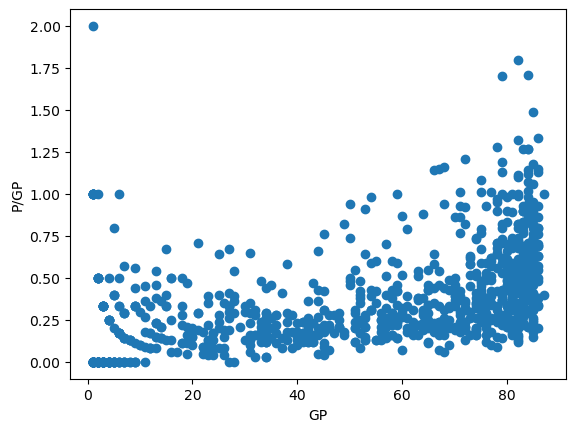

In [362]:
def mmss_to_seconds(mmss):
    minutes, seconds = map(int, mmss.split(":"))
    return minutes * 60 + seconds
final_df['TOI/GP'] = final_df['TOI/GP'].apply(mmss_to_seconds)


#print(final_df.columns)
plt.plot(final_df['GP'], final_df['P/GP'], 'o')
plt.xlabel("GP")
plt.ylabel("P/GP")

We recieve the following when reframing and replotting:

The new shape of our data is (671, 22)


,Player,S/C,Pos,GP,G,A,P,+/-,PIM,P/GP,...,PPG,PPP,SHG,SHP,OTG,GWG,S,S%,TOI/GP,FOW%
0,Nikita Kucherov,L,R,82,47,101,148,10,22,1.80,...,14,55,0,0,1,7,312,15.1,21:40,50
1,Nathan MacKinnon,R,C,84,52,92,144,34,52,1.71,...,11,50,0,0,2,9,412,12.6,22:48,46.4
2,Connor McDavid,L,C,79,32,102,134,30,32,1.70,...,7,45,1,1,1,5,271,11.8,21:22,51.5
3,Artemi Panarin,R,L,85,51,76,127,20,24,1.49,...,12,46,0,1,1,5,310,16.5,20:08,10
4,David Pastrnak,R,R,86,50,64,114,22,53,1.33,...,13,36,0,0,1,6,397,12.6,19:53,33.3


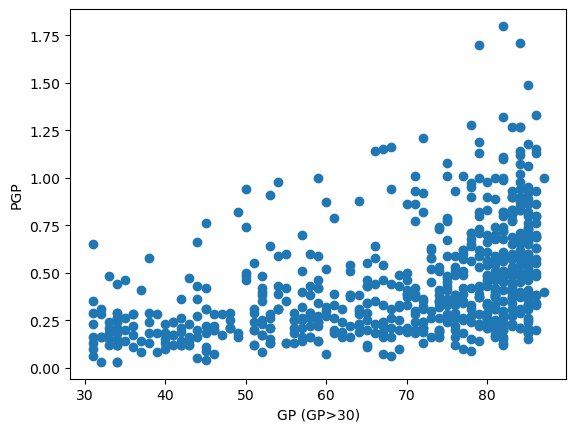

In [365]:
final_df = final_df[final_df['GP']>30]
print(f"The new shape of our data is", final_df.shape)
plt.plot(final_df['GP'], final_df['P/GP'], 'o')
plt.xlabel("GP (GP>30)")
plt.ylabel("PGP")
df.head()


In order to generate a working correlation matrix, the data needs to be further cleaned. The following opperations are carried out below

- Drop Players column
- Remove special Chars from column names
- 0/1 Binary Classifier for Handednes
- Position mapping 0-3
- Defense does not take a faceoff; convert NaN to 0

In [378]:
#WARNING: Running the following cell will alter the data frame! Rerun data load section to replay
#final_df = final_df.drop(columns = ['Player'])
final_df = final_df.rename(columns={'S/C':'Hand', '+/-':'PlusMinus', 'P/GP':'PGP', 'TOI/GP':'TOIGP', 'S%':'Sper', 'FOW%':"FOWper"})

sc_mapping = {'L': 0, 'R': 1}
pos_mapping = {'C':0, 'D':1, 'L':2, 'R':3}


final_df = final_df.replace({'Hand':sc_mapping, 'Pos':pos_mapping})
final_df.head()
final_df['Sper'] = pd.to_numeric(final_df['Sper'], errors = "coerce")
final_df['FOWper'] = pd.to_numeric(final_df['FOWper'], errors = "coerce")
final_df['FOWper'] = final_df['FOWper'].fillna(0)
final_df.head()

,Hand,Pos,GP,G,A,P,PlusMinus,PIM,PGP,EVG,...,PPG,PPP,SHG,SHP,OTG,GWG,S,Sper,TOIGP,FOWper
844,0,3,82,47,101,148,10,22,1.80,33,...,14,55,0,0,1,7,312,15.1,1300,50.0
845,1,0,84,52,92,144,34,52,1.71,41,...,11,50,0,0,2,9,412,12.6,1368,46.4
846,0,0,79,32,102,134,30,32,1.70,24,...,7,45,1,1,1,5,271,11.8,1282,51.5
847,1,2,85,51,76,127,20,24,1.49,39,...,12,46,0,1,1,5,310,16.5,1208,10.0
848,1,3,86,50,64,114,22,53,1.33,37,...,13,36,0,0,1,6,397,12.6,1193,33.3


Using a heat map it is apparent that there are quite a few highly correlated values. This indicates strong colinearity may be present, and will be confirmed in subsequent steps

<Axes: >

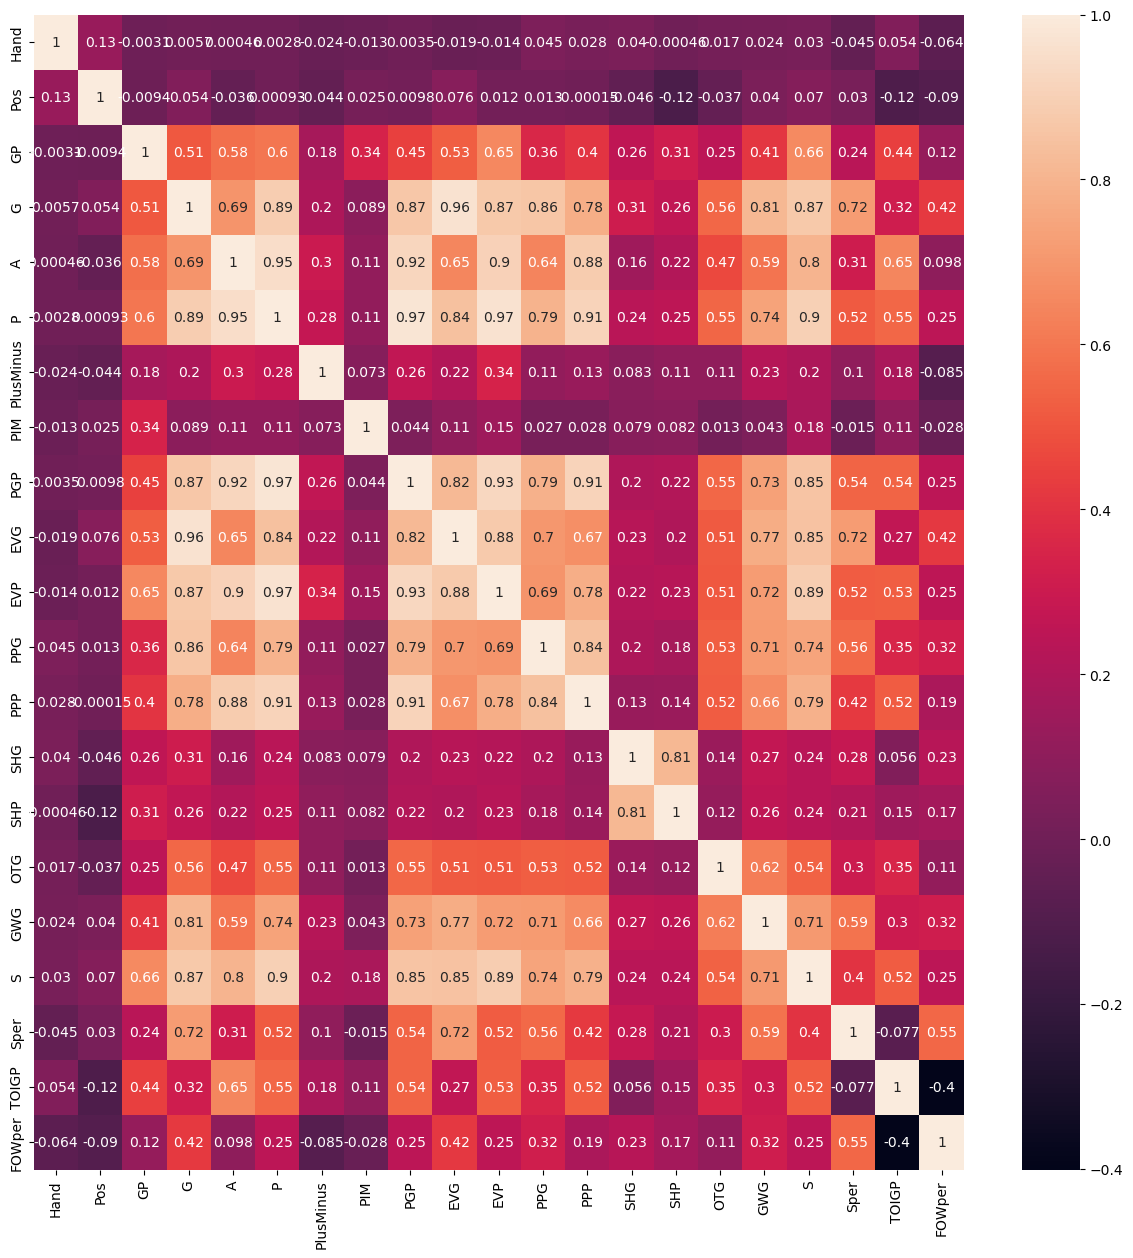

In [374]:
fig, ax = plt.subplots(figsize=(15, 15))
corr_df = final_df.corr()
sns.heatmap(corr_df, annot = True)

<ins>Models</ins>
<br/>
<br/>
In order to select the best features for the model, we can use the forward stepwise regression algorithm to optimize the R^2 value. We will use k to be the size of our array to test all possible predictors.

In [389]:
allowed_factors = [column for column in final_df.columns if column != "PGP"]
X_train, X_test = train_test_split(final_df, test_size = .33, random_state=0)

#define stepwise_forward algorithm
def stepwise_forward(k, allowed_factors, data): 
    best = ['', 0]
    selected_factors = []
    for k in range(1, k):
        for p in allowed_factors:
            #classification variables
            if p not in selected_factors:
                if p == 'Hand':
                    p = 'C(Hand)'
                if p == 'Pos':
                    p = 'C(Pos)'               
                model = smf.ols(formula=f'PGP ~ {" + ".join(selected_factors + [p])}', data=data).fit()
                adj_r2 = model.rsquared_adj
                #print(model.pvalues)
                if adj_r2 > best[1]:
                    best = [selected_factors + [p], adj_r2]
        selected_factors = best[0]
        #print(selected_factors)
        model = smf.ols(formula=f'PGP ~ {" + ".join(selected_factors + [p])}', data=data).fit()
    print(selected_factors)
    print(model.summary())
    return model

stepwise_forward(len(allowed_factors), allowed_factors, X_train)

['P', 'GP', 'TOIGP', 'C(Pos)', 'Sper', 'G', 'S', 'PlusMinus', 'C(Hand)', 'SHG', 'FOWper']
                            OLS Regression Results                            
Dep. Variable:                    PGP   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2094.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:45:00   Log-Likelihood:                 858.23
No. Observations:                 449   AIC:                            -1688.
Df Residuals:                     435   BIC:                            -1631.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

While this model has a very high  R^2 Value, we establish that there is linear dependence on several of the variables in the existing model by displaying the VIF values. 

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data)

      feature         VIF
0        Hand    1.620191
1         Pos    2.717650
2          GP   84.270876
3           G         inf
4           A         inf
5           P         inf
6   PlusMinus    1.315263
7         PIM    3.861184
8         PGP  173.518718
9         EVG         inf
10        EVP         inf
11        PPG         inf
12        PPP         inf
13        SHG         inf
14        SHP         inf
15        OTG    2.281775
16        GWG    6.336034
17          S   51.992410
18       Sper   26.319218
19      TOIGP   57.811631
20     FOWper    5.251061


/Users/mihirdixit/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


This makes sense as total points and points per game are dependent, and the other features with inf VIF are sub categories of points. Reffering back to our correlation matrix, we can remove values that are above the .7 threshold to combat the colinearity.

In [ ]:
lean_corr_df = X_train.corr()[X_train.corr()['PGP'] < .7]
dense_coor_df = X_train.corr()[X_train.corr()['PGP'] > .7]
#print(lean_corr_df)
lean_cols = [column for column in lean_corr_df.index]
dense_cols = [column for column in lean_corr_df.index]

#print(lean_cols)
lean_df = X_train[lean_cols]
dense_df = X_train[dense_cols]

lean_model = stepwise_forward(11, lean_cols, X_train)

['Sper']
['Sper', 'TOIGP']
['Sper', 'TOIGP', 'C(Pos)']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG', 'GP']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG', 'GP', 'SHG']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG', 'GP', 'SHG', 'C(Hand)']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG', 'GP', 'SHG', 'C(Hand)', 'PIM']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG', 'GP', 'SHG', 'C(Hand)', 'PIM']
['Sper', 'TOIGP', 'C(Pos)', 'PlusMinus', 'OTG', 'GP', 'SHG', 'C(Hand)', 'PIM']
                            OLS Regression Results                            
Dep. Variable:                    PGP   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          1.71e-133
Time:                        23:40:17

The model looks rather different now. The R^Squared value is down, but our model is comprised of a much more independent set of predictors. We can reproduce the VIF numbers to see this.

In [ ]:
vif_lean = pd.DataFrame()
vif_lean["feature"] = [column for column in lean_cols]
vif_lean["VIF"] = [variance_inflation_factor(lean_df.values, i)
                          for i in range(len(lean_cols))]
print(vif_lean)

      feature        VIF
0        Hand   1.585346
1         Pos   2.417522
2          GP  34.779935
3   PlusMinus   1.067958
4         PIM   3.802597
5         SHG   3.589463
6         SHP   4.006606
7         OTG   1.395809
8        Sper   7.633093
9       TOIGP  22.377784
10     FOWper   4.389582


In [ ]:
While there are 3 features still with VIF >5, this is a 

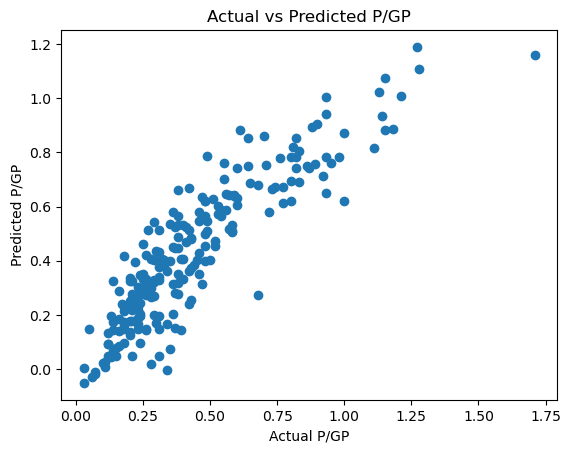

In [ ]:
y_test = X_test['PGP']
y_pred = lean_model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual P/GP')
plt.ylabel('Predicted P/GP')
plt.title('Actual vs Predicted P/GP')
plt.show()

<ins>Results</ins>
<br>
<br>
The Actual vs PRedicted P/GP plot visualizes that the model is relatively  on par with the actual values of P/GP

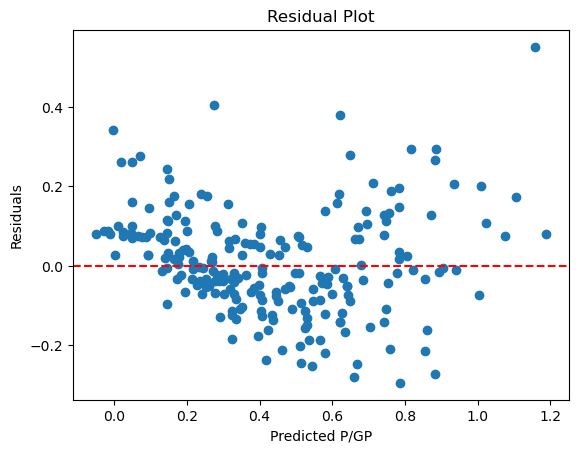

In [397]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted P/GP')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

The residuals also appear randomly distributed around 0 confirming the appropriate choice for a linear model

<ins>Conclusion</ins>
<br>
<br>
While there is a lot of chance in the game of ice hockey, the data here shows that there are some factors controlable by coaches or players that can influence the per game performance of a player. Features such as shot percentage, time on the ice, and position are expected to influence a player's points per game, players can focus on increasing face-off wins and reducing penalty minutes to positively impact this metric. It is also interesting to see that smaller point contributers like Overtime and Shorthanded goals are not in the top predictors of the lean data set (dropped highly correlated values)

Unfortunately with the amount of features present in the data, the pairplot that was generated was an impractical visualization for the initial data frame. 

For the future, I could improve this model by changing the feature set with supplemental data from additional sources and consider other models.